In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import missingno as msno
from sklearn.base import TransformerMixin
from datetime import datetime

In [170]:
pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

# Functions

In [3]:
class FeatureExtractorToSeries(TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        return x[self.column]

class FeatureExtractorToArray(FeatureExtractorToSeries):
    def transform(self, x, y=None):
        return x[self.column].values.reshape(-1,1)

In [4]:
def bleach(string):
    temp = ""
    string = str(string)
    if 'M' in string:
        for i in string:
            if i in ["1","2","3","4","5","6","7","8","9","0", "."]:
                temp += i
        if len(temp) > 0:
            return float(temp) * 1000000
    else:
        for i in string:
            if i in ["1","2","3","4","5","6","7","8","9","0", "."]:
                temp += i
        if len(temp) > 0:
            return float(temp)
        
def bleach_date(string):
    temp = ""
    string = str(string)
    for i in string:
        if i in ["1","2","3","4","5","6","7","8","9","0", ".", "/"]:
            temp += i
    if len(temp) > 0:
        return temp
    
def string_cleaner(string):
    return str(string).replace('\n', ' ').replace('\t', ' ').strip()
## replacing with whitespace character instead of empty string due to presence of line breaks in the middle of strings.
# Leading and trailing spaces created by this will still be stripped afterwards

# Feature Generation Functions

In [5]:
### DATETIME

###Date Added: let's convert it to a datetime object
# Looks to be zero-padded, so I think it can be first bleached and then converted on this format:

def get_datetime(dataframe):
    dataframe['date'] = dataframe['date_added'].apply(lambda x: datetime.strptime(bleach_date(x), "%m/%d/%y"))
    dataframe['brewery_date'] = dataframe['date_brewery_added'].apply(lambda x: datetime.strptime(bleach_date(x), "%m/%d/%y"))
    return dataframe[['date', 'brewery_date']].values

# print(datetime.strptime(bleach_date('listen up!!!! its 12/12/12!!!!'), "%d/%m/%y"))

# print(pd.to_datetime(str(bleach('this beer added on 10/04/15')), format='%m%d%y'))

### TEXT Data

def has_description(dataframe):
    dataframe['description_present'] = dataframe['description'].apply(lambda x: 1 if x is not None else 0)
    dataframe['brewery_description_present'] = dataframe['brewery_description'].apply(lambda x: 1 if x is not None else 0)
    return dataframe[['description_present', 'brewery_description_present']].values

def length_description(dataframe):
    dataframe['wordcount'] = dataframe['description'].apply(lambda x: len(x) if x is not None else 0)
    dataframe['brewery_wordcount'] = dataframe['brewery_description'].apply(lambda x: len(x) if x is not None else 0)
    return dataframe[['wordcount', 'brewery_wordcount']].values

### BOOLEANS
def get_oop(dataframe):
    return dataframe['oop'].values.reshape(-1, 1)

def get_account_status(dataframe):
    dataframe['official_account'] = dataframe['brewery_account_status'].apply(lambda x: 1 if x == 'Official' else 0)
    return dataframe['official_account'].values

def get_subsidiary(dataframe):
    dataframe['is_subsidiary'] = dataframe['subsidiary_id'].apply(lambda x: 1 if x is not None else 0)
## CATEGORICAL
### COLUMNS: styles, brewery type
# Style ought to be categorical, maybe create umbrellas for edge cases or large categories

### LOCATION DATA
### could break down into dummies by country, state, etc

def get_in_usa(dataframe):
    dataframe['in_usa'] = dataframe['brewery_location'].apply(lambda x: 1 if 'United States' in x else 0)


# Data Import

In [6]:
### this makes for much speedier data import. Can modify typing once the dataframe is a little slimmer

dtypes_dict = {
'Unnamed: 0':object, 'abv':object, 'beer_id':object, 'brewery':object, 
    'brewery_id':object, 'date_added':object, 'description':object, 'ibu':object, 
    'monthly_checkins':object, 'name':object, 'oop':object, 'raters':object, 'rating':object, 
    'style':object, 'total_checkins':object, 'unique_checkins':object 
}

In [7]:
filepath = 'data/master_all_untappd_data.csv'

df = pd.read_csv(filepath, dtype=dtypes_dict).iloc[:,1:].copy()

In [8]:
df = df[['name', 'brewery', 'style', 'rating', 'raters', 'abv', 'ibu', 
                     'total_checkins', 'unique_checkins', 'monthly_checkins', 
                     'date_added', 'description', 'beer_id', 'brewery_id', 'oop']].copy()
print(df.shape)
df.head()

(1984742, 15)


,name,brewery,style,rating,raters,abv,ibu,total_checkins,unique_checkins,monthly_checkins,date_added,description,beer_id,brewery_id,oop
0,Hocus Pocus,Magic Hat Brewing Company,Pale Wheat Ale - American,(3.23),"\n 10,481 Ratings ...",\n 4.5% ABV ...,\n 13 IBU ...,"14,978","12,295",236,\n Added 08/21/10 ...,Our take on a cla...,1,812,0
1,Grimbergen Blonde,Brouwerij Alken-Maes,Blonde Ale - Belgian Blonde / Golden,(3.51),"\n 62,345 Ratings ...",\n 6.7% ABV ...,\n 22 IBU ...,"93,350","69,473","2,285",\n Added 08/21/10 ...,When the first re...,2,264,0
2,Widdershins Oak Aged Barleywine Ale,Left Hand Brewing Company,Barleywine - English,(3.69),"\n 4,736 Ratings ...",\n 10.7% ABV ...,\n 65 IBU ...,"5,860","5,445",7,\n Added 11/15/13 ...,Widdershins is ou...,505601,779,0
3,Lucifer,Brouwerij Het Anker,Belgian Strong Golden Ale,(3.6),"\n 28,989 Ratings ...",\n 8% ABV ...,\n 24 IBU ...,"36,833","32,644",541,\n Added 12/24/10 ...,Lucifer entered t...,16551,284,0
4,Oxfordshire Bitter,Ridgeway Brewing,English Bitter,(3.29),\n 549 Ratings ...,\n 4% ABV ...,\n No IBU ...,706,647,7,\n Added 08/21/10 ...,,5,1056,0


In [9]:
breweries = pd.read_csv('data/master_untappd_brewery_data.csv')
breweries = breweries[['brewery_name', 'brewery_type', 'brewery_account_status',
       'brewery_description', 'brewery_location', 
       'brewery_num_beers', 'brewery_raters', 'brewery_rating', 
       'date_brewery_added', 'monthly_brewery_checkins', 'subsidiary_id',
       'subsidiary_name', 'total_brewery_checkins', 'unique_brewery_checkins', 'brewery_id', 'brewery_closed']].copy()
breweries.head()

,brewery_name,brewery_type,brewery_account_status,brewery_description,brewery_location,brewery_num_beers,brewery_raters,brewery_rating,date_brewery_added,monthly_brewery_checkins,subsidiary_id,subsidiary_name,total_brewery_checkins,unique_brewery_checkins,brewery_id,brewery_closed
0,\n\t\t\t\t\t\t\t\tMagic Hat Brewing Company\t\...,Micro Brewery,Official,\n\t\t\t\t\t\t\tWhere ancient alchemy meets mo...,"\n\t\t\t\t\t\t\t\tSouth Burlington, VT \t\t\t\...",76 Beers,"\n\t\t\t\t\t\t971,963 Ratings\t\t\t\t\t",(3.41),\n\t\t\t\t\t\tAdded 10/03/10\t\t\t\t\t,"15,671","[195747, 2336]","['Florida Ice and Farm Company S.A.', 'Cervece...",1.47M+,"374,324",812,0
1,\n\t\t\t\t\t\t\t\tBrouwerij Alken-Maes\t\t\t\t...,Macro Brewery,presumed_unclaimed,\n\t\t\t\t\t\t\tAlken-Maes was created out of ...,"\n\t\t\t\t\t\t\t\tMechelen, Antwerpen \t\t\t\t...",58 Beers,"\n\t\t\t\t\t\t259,350 Ratings\t\t\t\t\t",(3.45),\n\t\t\t\t\t\tAdded 10/13/10\t\t\t\t\t,"11,182","[1400, 344]","['Heineken', 'Carlsberg Group']","378,903","146,467",264,0
2,\n\t\t\t\t\t\t\t\tLeft Hand Brewing Company\t\...,Micro Brewery,Official,\n\t\t\t\t\t\t\tColorado brewers of America's ...,"\n\t\t\t\t\t\t\t\tLongmont, CO \t\t\t\t\t\t\t\...",347 Beers,"\n\t\t\t\t\t\t1,075,201 Ratings\t\t\t\t\t",(3.74),\n\t\t\t\t\t\tAdded 10/04/10\t\t\t\t\t,"24,185",NaN,NaN,1.58M+,"461,326",779,0
3,\n\t\t\t\t\t\t\t\tBrouwerij Het Anker\t\t\t\t\...,Micro Brewery,Official,\n\t\t\t\t\t\t\tHet Anker continuously strives...,"\n\t\t\t\t\t\t\t\tMechelen, Antwerpen \t\t\t\t...",27 Beers,"\n\t\t\t\t\t\t281,354 Ratings\t\t\t\t\t",(3.78),\n\t\t\t\t\t\tAdded 10/08/10\t\t\t\t\t,"12,177",NaN,NaN,"373,020","148,144",284,0
4,\n\t\t\t\t\t\t\t\tRidgeway Brewing\t\t\t\t\t\t\t,Micro Brewery,presumed_unclaimed,"\n\t\t\t\t\t\t\tRidgeway Brewing, in South Oxf...",\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tEngland\t\t\...,40 Beers,"\n\t\t\t\t\t\t82,131 Ratings\t\t\t\t\t",(3.34),\n\t\t\t\t\t\tAdded 10/12/10\t\t\t\t\t,575,NaN,NaN,"97,369","55,074",1056,0


In [10]:
breweries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173937 entries, 0 to 173936
Data columns (total 16 columns):
brewery_name                173936 non-null object
brewery_type                173937 non-null object
brewery_account_status      173937 non-null object
brewery_description         173937 non-null object
brewery_location            173937 non-null object
brewery_num_beers           173937 non-null object
brewery_raters              173937 non-null object
brewery_rating              36240 non-null object
date_brewery_added          173937 non-null object
monthly_brewery_checkins    173937 non-null object
subsidiary_id               724 non-null object
subsidiary_name             724 non-null object
total_brewery_checkins      173937 non-null object
unique_brewery_checkins     173937 non-null object
brewery_id                  173937 non-null int64
brewery_closed              173937 non-null int64
dtypes: int64(2), object(14)
memory usage: 21.2+ MB


# Drop Duplicates

In [11]:
dupes = df[df.duplicated()]
print(dupes.shape)
df = df.drop_duplicates()
df.shape

(349202, 15)


(1635540, 15)

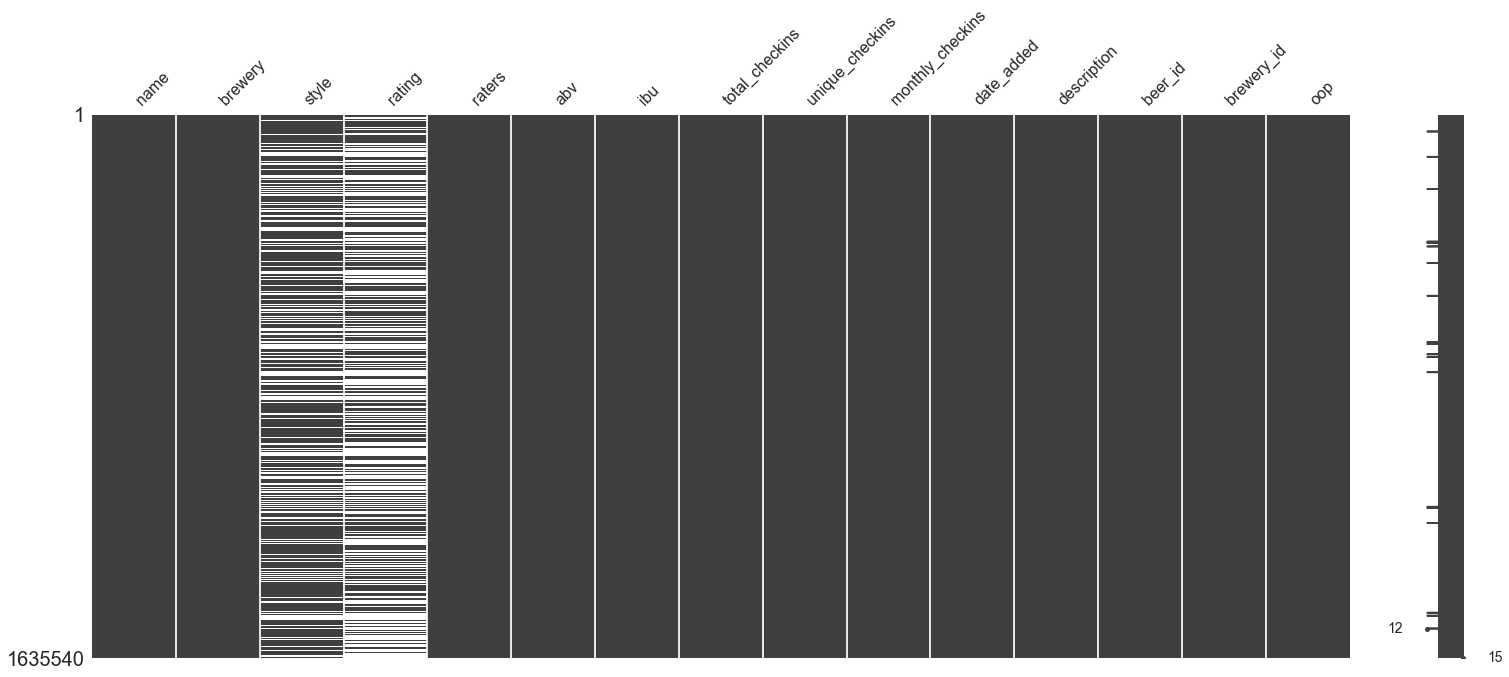

In [12]:
msno.matrix(df)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1635540 entries, 0 to 1984741
Data columns (total 15 columns):
name                1635527 non-null object
brewery             1635529 non-null object
style               1118691 non-null object
rating              739247 non-null object
raters              1635540 non-null object
abv                 1635540 non-null object
ibu                 1635540 non-null object
total_checkins      1635540 non-null object
unique_checkins     1635540 non-null object
monthly_checkins    1635540 non-null object
date_added          1635540 non-null object
description         1635540 non-null object
beer_id             1635540 non-null object
brewery_id          1635540 non-null object
oop                 1635540 non-null object
dtypes: object(15)
memory usage: 199.7+ MB


# Drop Rows without Rating

In [15]:
df['raters'] = df['raters'].apply(bleach)
print(df[df['raters'] < 10].shape)
df = df[df['raters'] >= 10].copy()
print(df.shape)

(896282, 15)
(739258, 15)


# Clean Beer DF

In [16]:
df['rating'] = df['rating'].apply(bleach)
df['raters'] = df['raters'].apply(bleach)
df['total_checkins'] = df['total_checkins'].apply(bleach)
df['unique_checkins'] = df['unique_checkins'].apply(bleach)
df['monthly_checkins'] = df['monthly_checkins'].apply(bleach)
df['name'] = df['name'].apply(string_cleaner)
df['brewery'] = df['brewery'].apply(string_cleaner)
df['abv'] = df['abv'].apply(bleach)
df['ibu'] = df['ibu'].apply(bleach)
df['date_added'] = df['date_added'].apply(bleach_date)
df['description'] = df['description'].apply(string_cleaner)
df['beer_id'] = df['beer_id'].apply(int)
df['brewery_id'] = df['brewery_id'].apply(int)
df['oop'] = df['oop'].apply(int)

In [17]:
print(len(df.description[4]))
df['description'] = df['description'].apply(lambda x: None if len(x) == 0 else x)

0


In [164]:
df['has_description'] = df['description'].apply(lambda x: 1 if x is not None else 0)
df['has_description'].describe()

count    739258.000000
mean          0.551802
std           0.497310
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: has_description, dtype: float64

In [18]:
df['date_added'] = df['date_added'].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))

(array([  66635.,   34003.,   37376.,   44725.,   59987.,   74337.,
          87968.,  105263.,  117152.,  111812.]),
 array([ 734005.,  734248.,  734491.,  734734.,  734977.,  735220.,
         735463.,  735706.,  735949.,  736192.,  736435.]),
 <a list of 10 Patch objects>)

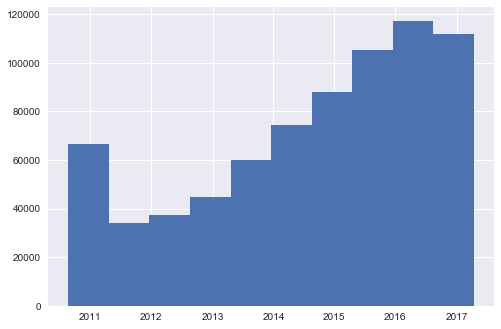

In [19]:
plt.hist(df['date_added'].values)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 739258 entries, 0 to 1984199
Data columns (total 15 columns):
name                739258 non-null object
brewery             739258 non-null object
style               723003 non-null object
rating              739247 non-null float64
raters              739258 non-null float64
abv                 686166 non-null float64
ibu                 297355 non-null float64
total_checkins      739258 non-null float64
unique_checkins     739258 non-null float64
monthly_checkins    739258 non-null float64
date_added          739258 non-null datetime64[ns]
description         407924 non-null object
beer_id             739258 non-null int64
brewery_id          739258 non-null int64
oop                 739258 non-null int64
dtypes: datetime64[ns](1), float64(7), int64(3), object(4)
memory usage: 90.2+ MB


In [167]:
df.head()

,name,brewery,style,rating,raters,abv,ibu,total_checkins,unique_checkins,monthly_checkins,date_added,description,beer_id,brewery_id,oop,has_description
0,Hocus Pocus,Magic Hat Brewing Company,Pale Wheat Ale - American,3.23,10481.0,4.5,13.0,14978.0,12295.0,236.0,2010-08-21,Our take on a classic summer ale. A toast to w...,1,812,0,1
1,Grimbergen Blonde,Brouwerij Alken-Maes,Blonde Ale - Belgian Blonde / Golden,3.51,62345.0,6.7,22.0,93350.0,69473.0,2285.0,2010-08-21,When the first regular breweries were founded ...,2,264,0,1
2,Widdershins Oak Aged Barleywine Ale,Left Hand Brewing Company,Barleywine - English,3.69,4736.0,10.7,65.0,5860.0,5445.0,7.0,2013-11-15,"Widdershins is our oak aged, counter-clockwise...",505601,779,0,1
3,Lucifer,Brouwerij Het Anker,Belgian Strong Golden Ale,3.60,28989.0,8.0,24.0,36833.0,32644.0,541.0,2010-12-24,Lucifer entered the market in the early 1980s ...,16551,284,0,1
4,Oxfordshire Bitter,Ridgeway Brewing,English Bitter,3.29,549.0,4.0,NaN,706.0,647.0,7.0,2010-08-21,None,5,1056,0,0


# Clean Breweries DF

In [21]:
breweries['brewery_name'] = breweries['brewery_name'].apply(string_cleaner)
breweries['brewery_description'] = breweries['brewery_description'].apply(string_cleaner)
breweries['brewery_location'] = breweries['brewery_location'].apply(string_cleaner)
breweries['brewery_num_beers'] = breweries['brewery_num_beers'].apply(bleach)
breweries['brewery_rating'] = breweries['brewery_rating'].apply(bleach)
breweries['brewery_raters'] = breweries['brewery_raters'].apply(bleach)
breweries['date_brewery_added'] = breweries['date_brewery_added'].apply(bleach_date)
breweries['total_brewery_checkins'] = breweries['total_brewery_checkins'].apply(bleach)
breweries['unique_brewery_checkins'] = breweries['unique_brewery_checkins'].apply(bleach)
breweries['monthly_brewery_checkins'] = breweries['monthly_brewery_checkins'].apply(bleach)
breweries['is_subsidiary'] = breweries['subsidiary_id'].apply(lambda x: 0 if pd.isnull(x) else 1)

In [22]:
breweries['date_brewery_added'] = breweries['date_brewery_added'].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))

In [23]:
breweries['brewery_type'].value_counts() ### should be encoded as dummy variables, but I'm not sure which I want to use

Home Brewery                114471
Micro Brewery                29657
Nano Brewery                  9875
Brew Pub                      6784
Bar / Restaurant / Store      6194
Cidery / Meadery              3943
Macro Brewery                 2669
Collaboration Brewery          344
Name: brewery_type, dtype: int64

In [24]:
print(breweries['brewery_account_status'].value_counts())
breweries['official_account'] = breweries['brewery_account_status'].apply(lambda x: 1 if x == 'Official' else 0)
breweries['official_account'].value_counts()

presumed_unclaimed    145777
Official               28160
Name: brewery_account_status, dtype: int64


0    145777
1     28160
Name: official_account, dtype: int64

In [25]:
breweries.drop('brewery_account_status', axis=1, inplace=True)

In [76]:
breweries = breweries.join(pd.get_dummies(breweries['brewery_type']))
breweries.drop('brewery_type', axis=1, inplace=True)

In [151]:
# len(breweries.ix[9, 'brewery_description'])
breweries['brewery_has_description'] = breweries['brewery_description'].apply(lambda x: 1 if len(x) > 0 else 0)
breweries['brewery_has_description'].sum()

14569

In [77]:
breweries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173937 entries, 0 to 173936
Data columns (total 24 columns):
brewery_name                173937 non-null object
brewery_description         173937 non-null object
brewery_location            173937 non-null object
brewery_num_beers           173937 non-null float64
brewery_raters              173937 non-null float64
brewery_rating              36240 non-null float64
date_brewery_added          173937 non-null datetime64[ns]
monthly_brewery_checkins    173937 non-null float64
subsidiary_id               724 non-null object
subsidiary_name             724 non-null object
total_brewery_checkins      173937 non-null float64
unique_brewery_checkins     173937 non-null float64
brewery_id                  173937 non-null int64
brewery_closed              173937 non-null int64
is_subsidiary               173937 non-null int64
official_account            173937 non-null int64
Bar / Restaurant / Store    173937 non-null uint8
Brew Pub            

In [152]:
breweries.head()

,brewery_name,brewery_description,brewery_location,brewery_num_beers,brewery_raters,brewery_rating,date_brewery_added,monthly_brewery_checkins,subsidiary_id,subsidiary_name,total_brewery_checkins,unique_brewery_checkins,brewery_id,brewery_closed,is_subsidiary,official_account,Bar / Restaurant / Store,Brew Pub,Cidery / Meadery,Collaboration Brewery,Home Brewery,Macro Brewery,Micro Brewery,Nano Brewery,United States,Norway,Brazil,England,Sweden,Netherlands,...,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,PR,PW,RI,SC,SD,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY,brewery_has_description
0,Magic Hat Brewing Company,Where ancient alchemy meets modern day science...,"South Burlington, VT United States",76.0,971963.0,3.41,2010-10-03,15671.0,"[195747, 2336]","['Florida Ice and Farm Company S.A.', 'Cervece...",1470000.0,374324.0,812,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,Brouwerij Alken-Maes,Alken-Maes was created out of the 1988 merger ...,"Mechelen, Antwerpen Belgium",58.0,259350.0,3.45,2010-10-13,11182.0,"[1400, 344]","['Heineken', 'Carlsberg Group']",378903.0,146467.0,264,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,Left Hand Brewing Company,Colorado brewers of America's original Nitro b...,"Longmont, CO United States",347.0,1075201.0,3.74,2010-10-04,24185.0,NaN,NaN,1580000.0,461326.0,779,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Brouwerij Het Anker,Het Anker continuously strives for an authenti...,"Mechelen, Antwerpen Belgium",27.0,281354.0,3.78,2010-10-08,12177.0,NaN,NaN,373020.0,148144.0,284,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,Ridgeway Brewing,"Ridgeway Brewing, in South Oxfordshire, is run...",England,40.0,82131.0,3.34,2010-10-12,575.0,NaN,NaN,97369.0,55074.0,1056,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# Engineering location features

In [96]:
countries = {}
for location in breweries['brewery_location'].values:
    if len(location.split(' ')) <= 2:
        if location in countries:
            countries[location] += 1
        else:
            countries[location] = 1

In [124]:
entries_by_country = sorted(countries.items(), reverse=True, key=lambda x: x[1])
top_twenty = []
for country in entries_by_country[0:20]:
    top_twenty.append(country[0])
top_twenty

['United States',
 'Norway',
 'Brazil',
 'England',
 'Sweden',
 'Netherlands',
 'Canada',
 'Germany',
 'Australia',
 'France',
 'Italy',
 'Belgium',
 'Russia',
 'Mexico',
 'Spain',
 'New Zealand',
 'Denmark',
 'Finland',
 'Scotland',
 'Czech Republic']

In [126]:
for country in top_twenty:
    breweries[country] = breweries['brewery_location'].apply(lambda x: 1 if country in x else 0)
    print('Done with %s column!!!' % country)

Done with United States column!!!
Done with Norway column!!!
Done with Brazil column!!!
Done with England column!!!
Done with Sweden column!!!
Done with Netherlands column!!!
Done with Canada column!!!
Done with Germany column!!!
Done with Australia column!!!
Done with France column!!!
Done with Italy column!!!
Done with Belgium column!!!
Done with Russia column!!!
Done with Mexico column!!!
Done with Spain column!!!
Done with New Zealand column!!!
Done with Denmark column!!!
Done with Finland column!!!
Done with Scotland column!!!
Done with Czech Republic column!!!


In [148]:
states_abrev = ["AK","AL","AR","AZ","CA","CO","CT","DC",
                "DE","FL","GA","GU","HI","IA","ID", "IL",
                "IN","KS","KY","LA","MA","MD","ME","MH",
                "MI","MN","MO","MS","MT","NC","ND","NE","NH",
                "NJ","NM","NV","NY", "OH","OK","OR","PA","PR",
                "PW","RI","SC","SD","TN","TX","UT","VA","VI",
                "VT","WA","WI","WV","WY"]
for state in states_abrev:
    breweries[state] = breweries['brewery_location'].apply(lambda x: 1 if state in x else 0)
    print('Done with %s column!!!' % state, breweries[state].sum())

Done with AK column!!! 51
Done with AL column!!! 83
Done with AR column!!! 57
Done with AZ column!!! 193
Done with CA column!!! 1443
Done with CO column!!! 541
Done with CT column!!! 212
Done with DC column!!! 50
Done with DE column!!! 92
Done with FL column!!! 480
Done with GA column!!! 172
Done with GU column!!! 16
Done with HI column!!! 48
Done with IA column!!! 151
Done with ID column!!! 88
Done with IL column!!! 522
Done with IN column!!! 278
Done with KS column!!! 86
Done with KY column!!! 90
Done with LA column!!! 114
Done with MA column!!! 341
Done with MD column!!! 223
Done with ME column!!! 143
Done with MH column!!! 0
Done with MI column!!! 595
Done with MN column!!! 276
Done with MO column!!! 253
Done with MS column!!! 27
Done with MT column!!! 92
Done with NC column!!! 436
Done with ND column!!! 36
Done with NE column!!! 123
Done with NH column!!! 113
Done with NJ column!!! 261
Done with NM column!!! 101
Done with NV column!!! 90
Done with NY column!!! 781
Done with OH col

In [147]:
breweries.head(20)

,brewery_name,brewery_description,brewery_location,brewery_num_beers,brewery_raters,brewery_rating,date_brewery_added,monthly_brewery_checkins,subsidiary_id,subsidiary_name,total_brewery_checkins,unique_brewery_checkins,brewery_id,brewery_closed,is_subsidiary,official_account,Bar / Restaurant / Store,Brew Pub,Cidery / Meadery,Collaboration Brewery,Home Brewery,Macro Brewery,Micro Brewery,Nano Brewery,United States,Norway,Brazil,England,Sweden,Netherlands,...,MO,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,PR,PW,RI,SC,SD,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY
0,Magic Hat Brewing Company,Where ancient alchemy meets modern day science...,"South Burlington, VT United States",76.0,971963.0,3.41,2010-10-03,15671.0,"[195747, 2336]","['Florida Ice and Farm Company S.A.', 'Cervece...",1470000.0,374324.0,812,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,Brouwerij Alken-Maes,Alken-Maes was created out of the 1988 merger ...,"Mechelen, Antwerpen Belgium",58.0,259350.0,3.45,2010-10-13,11182.0,"[1400, 344]","['Heineken', 'Carlsberg Group']",378903.0,146467.0,264,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Left Hand Brewing Company,Colorado brewers of America's original Nitro b...,"Longmont, CO United States",347.0,1075201.0,3.74,2010-10-04,24185.0,NaN,NaN,1580000.0,461326.0,779,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Brouwerij Het Anker,Het Anker continuously strives for an authenti...,"Mechelen, Antwerpen Belgium",27.0,281354.0,3.78,2010-10-08,12177.0,NaN,NaN,373020.0,148144.0,284,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Ridgeway Brewing,"Ridgeway Brewing, in South Oxfordshire, is run...",England,40.0,82131.0,3.34,2010-10-12,575.0,NaN,NaN,97369.0,55074.0,1056,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Charles Wells Brewery,We’re the UK’s largest privately owned brewing...,"Bedford, Bedfordshire England",123.0,475447.0,3.55,2010-10-10,10957.0,NaN,NaN,664208.0,322427.0,1348,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Samuel Smith's Old Brewery,"Samuel Smith brews at the Old Brewery, Tadcast...","Tadcaster, North Yorkshire England",44.0,506532.0,3.75,2010-10-05,9486.0,NaN,NaN,672639.0,282457.0,1099,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Empyrean Brewing Co.,It began with a dream that we could brew full-...,"Lincoln, NE United States",132.0,75834.0,3.59,2010-10-06,1946.0,NaN,NaN,111882.0,32033.0,501,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Fort Collins Brewery (FCB),Fort Collins Brewery & Modern Tavern is a fam...,"Fort Collins, CO United States",107.0,156329.0,3.45,2010-10-09,2029.0,NaN,NaN,198206.0,87666.0,545,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Upstream Brewing Company,,"Omaha, NE United States",387.0,34138.0,3.55,2010-10-09,889.0,NaN,NaN,43774.0,11860.0,9566,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Constructing Style Table

In [60]:
# df['style'].unique()
styles_df = pd.DataFrame(df['style'].unique(), columns=['style'])

In [165]:
ales = ['IPA - American', 'IPA - Imperial / Double', 'IPA - Black / Cascadian Dark Ale', 'IPA - Session / India Session Ale', 'IPA - English', 'IPA - Belgian', 'IPA - White', 'IPA - International', 'IPA - Triple', 'Rye IPA', 'IPA - Red', 'IPA - Imperial / Double Black',   
 'Pale Ale - American', 'Pale Ale - English', 'Pale Ale - Belgian', 'Pale Ale - International', 'Pale Ale - New Zealand', 'Pale Ale - Australian', 'Imperial Pale Ale', 
  'Saison / Farmhouse Ale', 'Belgian Tripel', 'Belgian Strong Dark Ale', 'Belgian Dubbel', 'Belgian Strong Golden Ale', 'Belgian Quad', 'Bière de Garde', 'Patersbier', 'Grisette', 'Bière de Champagne / Bière Brut', 'Sahti', 'Belgian Trappist Ale', 'Faro',     
   'Red Ale - American Amber / Red', 'Red Ale - Irish', 'Red Ale - Imperial / Double', 'Red Ale - Other',  
   'Blonde Ale', 'Golden Ale', 'Blonde Ale - Belgian Blonde / Golden', 'Kölsch', 'Cream Ale', 'Australian Sparkling Ale',   
   'Sour - Ale', 'Sour - Berliner Weisse', 'Sour - American Wild Ale', 'Sour - Gose', 'Sour - Flanders Red Ale', 'Lambic - Other', 'Sour - Gueuze', 'Lambic - Kriek', 'Lambic - Fruit', 'Sour - Flanders Oud Bruin', 'Sour - Farmhouse IPA', 'Lambic - Framboise',  
   'Hefeweizen', 'Witbier', 'Pale Wheat Ale - American', 'Dunkelweizen', 'Weizenbock', 'Kristallweizen', 'Hefeweizen Light / Leicht',    
   'Brown Ale - American', 'Brown Ale - English', 'Altbier', 'Brown Ale - Belgian', 'Brown Ale - Imperial / Double', 'Brown Ale - Other', 
   'Stout - American Imperial / Double', 'Stout - Other', 'Stout - Russian Imperial', 'Stout - Imperial / Double', 'Stout - Milk / Sweet', 'Stout - American', 'Stout - Oatmeal', 'Stout - Irish Dry', 'Stout - Imperial Oatmeal', 'Stout - Foreign / Export', 'Stout - Imperial Milk / Sweet', 'Stout - Oyster',  
   'Porter - Other', 'Porter - American', 'Porter - Imperial / Double', 'Porter - Baltic', 'Porter - English',   
   'English Bitter', 'Scotch Ale / Wee Heavy', 'Extra Special / Strong Bitter', 'English Mild Ale', 'Scottish Ale', 'Scottish Export Ale',
   'Barleywine - American', 'Barleywine - English', 'Strong Ale - American', 'Strong Ale - English', 'Wheat Wine', 'Barleywine - Other',   
   'Rye Beer', 'Roggenbier', 
   'Pumpkin / Yam Beer', 'Harvest Ale',
   'Dark Ale',
   'Winter Ale', 'Winter Warmer',
   'Old Ale', 'Gruit / Ancient Herbed Ale', 'Traditional Ale', 'Spiced / Herbed Beer'  
   'Grätzer / Grodziskie',
   'Black & Tan',
   'Burton Ale',
   'English Ale (Decommissioned)',
   'Dampfbier',
   'Mumme',
   'Smoked Beer', 
   ]
lagers = ['Pilsner - Other', 'Pilsner - German', 'Pilsner - Czech', 'Pilsner - Imperial / Double',  
'Lager - Pale', 'Lager - Euro', 'Lager - Helles', 'Lager - Vienna', 'Lager - Dark', 'Lager - Dunkel Munich', 'Lager - IPL (India Pale Lager)', 'Lager - American Amber / Red', 'Lager - Amber', 'Lager - Dortmunder / Export', 'Lager - Euro Dark', 'Lager - Red',   
'Lager - North American Adjunct', 'Lager - American Light', 'Malt Liquor', 'Malt Beer', 'California Common', 'Lager - Winter', 'Lager - Euro Strong', 'Lager - Japanese Rice', 'Happoshu',   
'Schwarzbier', 'Rauchbier', 
'Märzen', 'Festbier', 'Bock', 'Doppelbock', 'Maibock/Helles Bock', 'Maibock / Heller (Helles) Bock', 'Kellerbier / Zwickelbier', 'Zoigl']

others = ['Perry', 'Cider', 'Fruit Beer', 'Cyser', 'Braggot', 'Applewine', 'Pyment', 'Other', 'Mead', 'Shandy / Radler', 'Non-Alcoholic', 'Gluten-Free', 'Root Beer', 'Ginger Beer', 'Specialty Grain', 'Melomel', 'Eisbock', 'Kombucha', 'Kvass']

ipas = ['IPA - American', 'IPA - Imperial / Double', 'IPA - Black / Cascadian Dark Ale', 'IPA - Session / India Session Ale', 'IPA - English', 'IPA - Belgian', 'IPA - White', 'IPA - International', 'IPA - Triple', 'Rye IPA', 'IPA - Red', 'IPA - Imperial / Double Black', 'Sour - Farmhouse IPA', 'Lager - IPL (India Pale Lager)']

pale_ales = ['Pale Ale - American', 'Pale Ale - English', 'Pale Ale - Belgian', 'Pale Ale - International', 'Pale Ale - New Zealand', 'Pale Ale - Australian', 'Imperial Pale Ale', 'Pale Wheat Ale - American']

sours = ['Sour - Ale', 'Sour - Berliner Weisse', 'Sour - American Wild Ale', 'Sour - Gose', 'Sour - Flanders Red Ale', 'Lambic - Other', 'Sour - Gueuze', 'Lambic - Kriek', 'Lambic - Fruit', 'Sour - Flanders Oud Bruin', 'Sour - Farmhouse IPA', 'Lambic - Framboise']

pilsners = ['Pilsner - Other', 'Pilsner - German', 'Pilsner - Czech', 'Pilsner - Imperial / Double']

wheats = ['Hefeweizen', 'Witbier', 'Pale Wheat Ale - American', 'Dunkelweizen', 'Weizenbock', 'Kristallweizen', 'Hefeweizen Light / Leicht', 'Wheat Wine']

ambers = ['Red Ale - American Amber / Red', 'Red Ale - Irish', 'Red Ale - Imperial / Double', 'Red Ale - Other', 'Lager - American Amber / Red', 'Lager - Amber', 'Lager - Red', 'IPA - Red']

light_ales = ['Blonde Ale', 'Golden Ale', 'Blonde Ale - Belgian Blonde / Golden', 'Kölsch', 'Cream Ale', 'Australian Sparkling Ale']

yeasty_belgians = ['Saison / Farmhouse Ale', 'Belgian Tripel', 'Belgian Strong Dark Ale', 'Belgian Dubbel', 'Belgian Strong Golden Ale', 'Belgian Quad', 'Bière de Garde', 'Patersbier', 'Grisette', 'Bière de Champagne / Bière Brut', 'Sahti', 'Belgian Trappist Ale', 'Faro']

browns = ['Brown Ale - American', 'Brown Ale - English', 'Altbier', 'Brown Ale - Belgian', 'Brown Ale - Imperial / Double', 'Brown Ale - Other']

stouts = ['Stout - American Imperial / Double', 'Stout - Other', 'Stout - Russian Imperial', 'Stout - Imperial / Double', 'Stout - Milk / Sweet', 'Stout - American', 'Stout - Oatmeal', 'Stout - Irish Dry', 'Stout - Imperial Oatmeal', 'Stout - Foreign / Export', 'Stout - Imperial Milk / Sweet', 'Stout - Oyster']

porters = ['Porter - Other', 'Porter - American', 'Porter - Imperial / Double', 'Porter - Baltic', 'Porter - English']

subpremiums = ['Lager - North American Adjunct', 'Lager - American Light', 'Malt Liquor', 'Malt Beer']

lager_lager = ['Lager - Pale', 'Lager - Euro', 'Lager - Helles', 'Lager - Vienna', 'Lager - Dark', 'Lager - Dunkel Munich', 'Lager - IPL (India Pale Lager)', 'Lager - American Amber / Red', 'Lager - Amber', 'Lager - Dortmunder / Export', 'Lager - Euro Dark', 'Lager - Red', 'California Common', 'Lager - Winter', 'Lager - Euro Strong', 'Lager - Japanese Rice', 'Happoshu', 'Schwarzbier']

fall_winter = ['Lager - Winter', 'Pumpkin / Yam Beer', 'Harvest Ale', 'Winter Ale', 'Winter Warmer']

thicks = ['Barleywine - American', 'Barleywine - English', 'Strong Ale - American', 'Strong Ale - English', 'Wheat Wine', 'Barleywine - Other']

trad_brit = ['Burton Ale', 'English Bitter', 'Scotch Ale / Wee Heavy', 'Extra Special / Strong Bitter', 'English Mild Ale', 'Scottish Ale', 'Scottish Export Ale']

trad_german = ['Schwarzbier', 'Rauchbier', 
'Märzen', 'Festbier', 'Bock', 'Doppelbock', 'Maibock/Helles Bock', 'Maibock / Heller (Helles) Bock', 'Kellerbier / Zwickelbier', 'Zoigl']

spiced = ['Old Ale', 'Gruit / Ancient Herbed Ale', 'Traditional Ale', 'Spiced / Herbed Beer']

ryes = ['Rye Beer', 'Roggenbier', 'Rye IPA']

smokes = ['Grätzer / Grodziskie', 'Rauchbier', 'Smoked Beer']

strongs = ['IPA - Imperial / Double', 'IPA - Triple', 'Imperial Pale Ale', 'Pilsner - Imperial / Double', 'Red Ale - Imperial / Double', 'Belgian Quad', 'Belgian Tripel', 'Belgian Strong Dark Ale', 'Porter - Imperial / Double', 'Lager - Euro Strong', 'Brown Ale - Imperial / Double']

In [166]:
style_classes = {'smokes':smokes, 'ryes':ryes, 'spiced':spiced, 'trad_german':trad_german, 'trad_brit':trad_brit,
                 'thicks':thicks, 'fall_winter':fall_winter, 'lager_lager':lager_lager, 'subpremiums':subpremiums,
                'porters':porters, 'stouts':stouts, 'browns':browns, 'yeasty_belgians':yeasty_belgians,
                 'light_ales':light_ales, 'ambers':ambers, 'wheats':wheats, 'pilsners':pilsners, 'sours':sours,
                 'pale_ales':pale_ales, 'ipas':ipas, 'ales':ales, 'lagers':lagers, 'others':others, 'strongs':strongs}

style_classes.keys()

for a_style in style_classes.keys():
    col_name = 'in_%s' % a_style
    styles_df[col_name] = styles_df['style'].apply(lambda x: 1 if x in style_classes[a_style] else 0)
styles_df.head(20)

,style,in_smokes,in_ryes,in_spiced,in_trad_german,in_trad_brit,in_thicks,in_fall_winter,in_lager_lager,in_subpremiums,in_porters,in_stouts,in_browns,in_yeasty_belgians,in_light_ales,in_ambers,in_wheats,in_pilsners,in_sours,in_pale_ales,in_ipas,in_ales,in_lagers,in_others,style_frequency,in_strongs
0,Pale Wheat Ale - American,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,7891.0,0
1,Blonde Ale - Belgian Blonde / Golden,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,6924.0,0
2,Barleywine - English,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2767.0,0
3,Belgian Strong Golden Ale,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,5186.0,0
4,English Bitter,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,8871.0,0
5,Winter Warmer,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2438.0,0
6,Winter Ale,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4257.0,0
7,Stout - Oatmeal,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,6046.0,0
8,Stout - American,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,7818.0,0
9,Spiced / Herbed Beer,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5503.0,0


In [107]:
print(len(df['style'].value_counts().values))
style_counts = pd.DataFrame(df['style'].value_counts())
style_counts.columns = ['style_frequency']
type(style_counts)
style_counts.head()

168


,style_frequency
IPA - American,67894
Pale Ale - American,39972
Saison / Farmhouse Ale,29515
IPA - Imperial / Double,25655
Red Ale - American Amber / Red,17126


In [109]:
styles_df = pd.merge(styles_df, style_counts, how='left', left_on='style', right_index=True)
styles_df.head()

,style,in_smokes,in_ryes,in_spiced,in_trad_german,in_trad_brit,in_thicks,in_fall_winter,in_lager_lager,in_subpremiums,in_porters,in_stouts,in_browns,in_yeasty_belgians,in_light_ales,in_ambers,in_wheats,in_pilsners,in_sours,in_pale_ales,in_ipas,in_ales,in_lagers,in_others,style_frequency
0,Pale Wheat Ale - American,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,7891.0
1,Blonde Ale - Belgian Blonde / Golden,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,6924.0
2,Barleywine - English,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2767.0
3,Belgian Strong Golden Ale,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,5186.0
4,English Bitter,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,8871.0


In [110]:
styles_df.iloc[50, :] ## looks good!!!

style                 IPA - Red
in_smokes                     0
in_ryes                       0
in_spiced                     0
in_trad_german                0
in_trad_brit                  0
in_thicks                     0
in_fall_winter                0
in_lager_lager                0
in_subpremiums                0
in_porters                    0
in_stouts                     0
in_browns                     0
in_yeasty_belgians            0
in_light_ales                 0
in_ambers                     1
in_wheats                     0
in_pilsners                   0
in_sours                      0
in_pale_ales                  0
in_ipas                       1
in_ales                       1
in_lagers                     0
in_others                     0
style_frequency            1094
Name: 50, dtype: object

# Databasing

In [168]:
df.to_csv('data/database/beers_table.csv')
breweries.to_csv('data/database/breweries_table.csv')
styles_df.to_csv('data/database/styles_df.csv')

# Data Joining

In [169]:
joined = pd.merge(df, breweries, how='left', on=['brewery_id', 'brewery_id'])
joined = pd.merge(joined, styles_df, how='left', on=['style', 'style'])
print(joined.shape)
joined.head()

(739258, 141)


,name,brewery,style,rating,raters,abv,ibu,total_checkins,unique_checkins,monthly_checkins,date_added,description,beer_id,brewery_id,oop,has_description,brewery_name,brewery_description,brewery_location,brewery_num_beers,brewery_raters,brewery_rating,date_brewery_added,monthly_brewery_checkins,subsidiary_id,subsidiary_name,total_brewery_checkins,unique_brewery_checkins,brewery_closed,is_subsidiary,...,WA,WI,WV,WY,brewery_has_description,in_smokes,in_ryes,in_spiced,in_trad_german,in_trad_brit,in_thicks,in_fall_winter,in_lager_lager,in_subpremiums,in_porters,in_stouts,in_browns,in_yeasty_belgians,in_light_ales,in_ambers,in_wheats,in_pilsners,in_sours,in_pale_ales,in_ipas,in_ales,in_lagers,in_others,style_frequency,in_strongs
0,Hocus Pocus,Magic Hat Brewing Company,Pale Wheat Ale - American,3.23,10481.0,4.5,13.0,14978.0,12295.0,236.0,2010-08-21,Our take on a classic summer ale. A toast to w...,1,812,0,1,Magic Hat Brewing Company,Where ancient alchemy meets modern day science...,"South Burlington, VT United States",76.0,971963.0,3.41,2010-10-03,15671.0,"[195747, 2336]","['Florida Ice and Farm Company S.A.', 'Cervece...",1470000.0,374324.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,7891.0,0
1,Grimbergen Blonde,Brouwerij Alken-Maes,Blonde Ale - Belgian Blonde / Golden,3.51,62345.0,6.7,22.0,93350.0,69473.0,2285.0,2010-08-21,When the first regular breweries were founded ...,2,264,0,1,Brouwerij Alken-Maes,Alken-Maes was created out of the 1988 merger ...,"Mechelen, Antwerpen Belgium",58.0,259350.0,3.45,2010-10-13,11182.0,"[1400, 344]","['Heineken', 'Carlsberg Group']",378903.0,146467.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,6924.0,0
2,Widdershins Oak Aged Barleywine Ale,Left Hand Brewing Company,Barleywine - English,3.69,4736.0,10.7,65.0,5860.0,5445.0,7.0,2013-11-15,"Widdershins is our oak aged, counter-clockwise...",505601,779,0,1,Left Hand Brewing Company,Colorado brewers of America's original Nitro b...,"Longmont, CO United States",347.0,1075201.0,3.74,2010-10-04,24185.0,NaN,NaN,1580000.0,461326.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2767.0,0
3,Lucifer,Brouwerij Het Anker,Belgian Strong Golden Ale,3.60,28989.0,8.0,24.0,36833.0,32644.0,541.0,2010-12-24,Lucifer entered the market in the early 1980s ...,16551,284,0,1,Brouwerij Het Anker,Het Anker continuously strives for an authenti...,"Mechelen, Antwerpen Belgium",27.0,281354.0,3.78,2010-10-08,12177.0,NaN,NaN,373020.0,148144.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,5186.0,0
4,Oxfordshire Bitter,Ridgeway Brewing,English Bitter,3.29,549.0,4.0,NaN,706.0,647.0,7.0,2010-08-21,None,5,1056,0,0,Ridgeway Brewing,"Ridgeway Brewing, in South Oxfordshire, is run...",England,40.0,82131.0,3.34,2010-10-12,575.0,NaN,NaN,97369.0,55074.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,8871.0,0


In [155]:
joined['United States'].sum()

454438.0

In [171]:
joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 739258 entries, 0 to 739257
Columns: 141 entries, name to in_strongs
dtypes: datetime64[ns](2), float64(102), int64(28), object(9)
memory usage: 800.9+ MB


Missing 11 entries for rating and just over 16,000 for style = 2% of data

In [172]:
print(joined[joined['brewery_name'].isnull()].shape)
joined.dropna(axis=0, subset=['brewery_name'], inplace=True)

(17173, 141)


In [173]:
print(joined[joined['style'].isnull()].shape)
joined.dropna(axis=0, subset=['style'], inplace=True)

(15825, 141)


In [174]:
print(joined[joined['rating'].isnull()].shape)
joined.dropna(axis=0, subset=['rating'], inplace=True)

(11, 141)


In [175]:
joined.head()

,name,brewery,style,rating,raters,abv,ibu,total_checkins,unique_checkins,monthly_checkins,date_added,description,beer_id,brewery_id,oop,has_description,brewery_name,brewery_description,brewery_location,brewery_num_beers,brewery_raters,brewery_rating,date_brewery_added,monthly_brewery_checkins,subsidiary_id,subsidiary_name,total_brewery_checkins,unique_brewery_checkins,brewery_closed,is_subsidiary,official_account,Bar / Restaurant / Store,Brew Pub,Cidery / Meadery,Collaboration Brewery,Home Brewery,Macro Brewery,Micro Brewery,Nano Brewery,United States,Norway,Brazil,England,Sweden,Netherlands,Canada,Germany,Australia,France,Italy,...,NH,NJ,NM,NV,NY,OH,OK,OR,PA,PR,PW,RI,SC,SD,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY,brewery_has_description,in_smokes,in_ryes,in_spiced,in_trad_german,in_trad_brit,in_thicks,in_fall_winter,in_lager_lager,in_subpremiums,in_porters,in_stouts,in_browns,in_yeasty_belgians,in_light_ales,in_ambers,in_wheats,in_pilsners,in_sours,in_pale_ales,in_ipas,in_ales,in_lagers,in_others,style_frequency,in_strongs
0,Hocus Pocus,Magic Hat Brewing Company,Pale Wheat Ale - American,3.23,10481.0,4.5,13.0,14978.0,12295.0,236.0,2010-08-21,Our take on a classic summer ale. A toast to w...,1,812,0,1,Magic Hat Brewing Company,Where ancient alchemy meets modern day science...,"South Burlington, VT United States",76.0,971963.0,3.41,2010-10-03,15671.0,"[195747, 2336]","['Florida Ice and Farm Company S.A.', 'Cervece...",1470000.0,374324.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,7891.0,0
1,Grimbergen Blonde,Brouwerij Alken-Maes,Blonde Ale - Belgian Blonde / Golden,3.51,62345.0,6.7,22.0,93350.0,69473.0,2285.0,2010-08-21,When the first regular breweries were founded ...,2,264,0,1,Brouwerij Alken-Maes,Alken-Maes was created out of the 1988 merger ...,"Mechelen, Antwerpen Belgium",58.0,259350.0,3.45,2010-10-13,11182.0,"[1400, 344]","['Heineken', 'Carlsberg Group']",378903.0,146467.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,6924.0,0
2,Widdershins Oak Aged Barleywine Ale,Left Hand Brewing Company,Barleywine - English,3.69,4736.0,10.7,65.0,5860.0,5445.0,7.0,2013-11-15,"Widdershins is our oak aged, counter-clockwise...",505601,779,0,1,Left Hand Brewing Company,Colorado brewers of America's original Nitro b...,"Longmont, CO United States",347.0,1075201.0,3.74,2010-10-04,24185.0,NaN,NaN,1580000.0,461326.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2767.0,0
3,Lucifer,Brouwerij Het Anker,Belgian Strong Golden Ale,3.60,28989.0,8.0,24.0,36833.0,32644.0,541.0,2010-12-24,Lucifer entered the market in the early 1980s ...,16551,284,0,1,Brouwerij Het Anker,Het Anker continuously strives for an authenti...,"Mechelen, Antwerpen Belgium",27.0,281354.0,3.78,2010-10-08,12177.0,NaN,NaN,373020.0,148144.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,5186.0,0
4,Oxfordshire Bitter,Ridgeway Brewing,English Bitter,3.29,549.0,4.0,NaN,706.0,647.0,7.0,2010-08-21,None,5,1056,0,0,Ridgeway Brewing,"Ridgeway Brewing, in South Oxfordshire, is run...",England,40.0,82131.0,3.34,2010-10-12,575.0,NaN,NaN,97369.0,55074.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0

In [176]:
joined.to_csv('data/database/master.csv')

In [95]:
type(joined['date_added'][0])

pandas.tslib.Timestamp

# List of Styles for Beer Taxonomy

In [125]:
with open('data/all_styles.txt', 'w') as f:
    f.write(','.join(df['style'].value_counts().index))

In [99]:
print(len(df['style'].value_counts().values))
style_counts = df['style'].value_counts()
type(style_counts)

168


pandas.core.series.Series

NOTE TO SELF: An empty list for the subsidiary indicates that the brewery is in fact a subsidiary of another brewery/conglomerate but the page was unlinked to the parent brewery. An empty list has a length of zero but is objectively different from a missing value.

Still have a lot of work to do on location data.

In [68]:
joined.brewery.value_counts()

Rock Bottom Restaurant & Brewery           2499
Stone Brewing                              2196
Mikkeller                                  2078
McMenamins                                 2054
Ballast Point Brewing & Spirits            1879
Cigar City Brewing                         1802
Sierra Nevada Brewing Co.                  1671
Dogfish Head Craft Brewery                 1640
Founders Brewing Co.                       1435
Lagunitas Brewing Company                  1273
New Belgium Brewing Company                1263
Oskar Blues Brewery                        1242
Goose Island Beer Co.                      1187
Boston Beer Company                        1142
Tired Hands Brewing Company                1126
The Bruery                                 1092
Deschutes Brewery                          1069
BrewDog                                    1067
Bell's Brewery                             1018
Odell Brewing Co.                          1017
Victory Brewing Company                 